In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

import warnings
warnings.filterwarnings('ignore')

In [2]:
def check_dataframe(dataframe):
    """Input checking function to check for dataframes.
    """
    assert isinstance(dataframe, pd.DataFrame), ("The input data"
        "set needs to be a pandas DataFrame.")

    
def modify_dataframe(df):
    check_dataframe(df)
    sig_pep_key = 'Signal peptide'
    seq_key = 'Sequence'
    mass_key = 'Mass'
    length_key = 'Length'
    
    df['PI'] = 0
    del df['Features']
    del df['Disulfide bond']
    for i, row in df.iterrows():
        signal_loc_str = row.loc[sig_pep_key].split(';')[0]
        sig_range = signal_loc_str.split()[-1]
        start, end = map(lambda x: int(x) - 1 if x.isnumeric() else 20, sig_range.split('..'))
        end += 1
        
        orig = row.loc[seq_key]
        modified_seq = orig[:start] + orig[end:]
        
        mass = molecular_weight(modified_seq, seq_type='protein')
        seq_obj = IP(modified_seq)
        
        df.loc[i, seq_key] = modified_seq
        df.loc[i, length_key] = len(modified_seq)
        df.loc[i, mass_key] = round(mass)
        df.loc[i, 'PI'] = seq_obj.pi()


def fix_mass(df):
    check_dataframe(df)
    for i, row in df.iterrows():
        orig_mass = row['Mass']
        df.loc[i, 'Mass'] = int(orig_mass.replace(',', ''))


def add_PI(df):
    check_dataframe(df)
    sig_pep_key = 'Signal peptide'
    seq_key = 'Sequence'
    mass_key = 'Mass'
    length_key = 'Length'
    
    df['PI'] = 0
    for i, row in df.iterrows():
        orig = row.loc[seq_key]
        seq_obj = IP(orig)
        df.loc[i, 'PI'] = seq_obj.pi()
        
        
def add_biopython_protein_analysis(df):
    check_dataframe(df)
    sig_pep_key = 'Signal peptide'
    seq_key = 'Sequence'
    mass_key = 'Mass'
    length_key = 'Length'
    
    df['Aromaticity'] = 0
    df['Instability'] = 0
    df['Ex_coeff_red_cysteines'] = 0
    df['Ex_coeff_disulfide_bridges'] = 0
    df['Helix_percent'] = 0
    df['Turn_percent'] = 0
    df['Sheet_percent'] = 0
    df['Flexibility'] = 0
    for i, row in df.iterrows():
        orig = row.loc[seq_key]
        seq_obj = ProteinAnalysis(orig)
        df.loc[i, 'Aromaticity'] = seq_obj.aromaticity()
        df.loc[i, 'Instability'] = seq_obj.instability_index()
        molar_extinction = seq_obj.molar_extinction_coefficient()
        df.loc[i, 'Ex_coeff_red_cysteines'] = molar_extinction[0]
        df.loc[i, 'Ex_coeff_disulfide_bridges'] = molar_extinction[1]
        sec_structure = seq_obj.secondary_structure_fraction()
        df.loc[i, 'Helix_percent'] = sec_structure[0]
        df.loc[i, 'Turn_percent'] = sec_structure[1]
        df.loc[i, 'Sheet_percent'] = sec_structure[2]
        flexibility = seq_obj.flexibility()
        df.loc[i, 'Flexibility'] = sum(flexibility)/len(flexibility)
        

In [3]:
params = pd.read_csv('Params.csv', header=None)
lst = params[0].values
params.set_index(lst, inplace=True)
del params[0]

In [4]:
from collections import defaultdict
params_dict = defaultdict(list)

for i, row in params.iterrows():
    for position in range(1, len(row) + 1):
        params_dict[i].append(float(row.loc[position]))


def get_tm_dg(df):
    seq_key = 'Sequence'
    df['dG'] = 0
    for i, row in df.iterrows():
        seq = row.loc[seq_key]
        if len(seq) < 19:
            continue
        dg_values = []
        for j in range(len(seq)-18):
            running_total = 0
            new_segment = seq[j:j+19]
            for k, aa in enumerate(new_segment):
                if aa == 'U':
                    pass
                else:
                    running_total += params_dict[aa][k]
            dg_values.append(running_total) 
        df.loc[i, 'dG'] = min(dg_values)


In [5]:
def plot_function(feature):
    sns.distplot(secreted[feature], hist=False, kde=True, label='Secreted (Full Sequence)')
    sns.distplot(secreted_noSP[feature], hist=False, kde=True, label='Secreted (Modified Sequence)')
    sns.distplot(cytoplasm[feature], hist=False, kde=True, label='Cytoplasm')
    sns.distplot(transmembrane[feature], hist=False, kde=True, label='Transmembrane')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.title(feature)

In [6]:
def remove_ambiguous_aa(df):
    check_dataframe(df)
    seq_key = 'Sequence'
    ambiguous_aa = ['X', 'B', 'U']
    for aa in ambiguous_aa:
        df = df[~df[seq_key].str.contains(aa)]
    return df

In [7]:
# First, import the human data set (secreted, cytoplasmic, and transmembrane)
secreted = pd.read_csv('secreted.csv')
cytoplasm = pd.read_csv('cytoplasm.csv')
transmembrane = pd.read_csv('transmembrane.csv')
secreted_noSP = secreted.copy(deep=True)
modify_dataframe(secreted_noSP)

data_list = [secreted, cytoplasm, transmembrane]
data_list2 = [secreted, cytoplasm, transmembrane, secreted_noSP]

secreted = remove_ambiguous_aa(secreted)
add_biopython_protein_analysis(secreted)
transmembrane = remove_ambiguous_aa(transmembrane)
add_biopython_protein_analysis(transmembrane)
cytoplasm = remove_ambiguous_aa(cytoplasm)
add_biopython_protein_analysis(cytoplasm)
secreted_noSP = remove_ambiguous_aa(secreted_noSP)
add_biopython_protein_analysis(secreted_noSP)

In [8]:
fix_mass(secreted)
fix_mass(cytoplasm)
fix_mass(transmembrane)
add_PI(secreted)
add_PI(cytoplasm)
add_PI(transmembrane)
get_tm_dg(secreted)
get_tm_dg(cytoplasm)
get_tm_dg(transmembrane)
get_tm_dg(secreted_noSP)

In [9]:
secreted.head()

,Entry,Protein names,Sequence,Length,Mass,Features,Disulfide bond,Signal peptide,Aromaticity,Instability,Ex_coeff_red_cysteines,Ex_coeff_disulfide_bridges,Helix_percent,Turn_percent,Sheet_percent,Flexibility,PI,dG
0,Q8IWL1,Pulmonary surfactant-associated protein A2 (PS...,MWLCPLALNLILMAASGAACEVKDVCVGSPGIPGTPGSHGLPGRDG...,248,26182,Chain (1); Disulfide bond (3); Domain (2); Gly...,"DISULFID 26; /note=""Interchain""; /evidence=""...",SIGNAL 1..20,0.068548,34.982661,28420,28920,0.221774,0.350806,0.237903,1.008313,5.072107,0.48
1,Q8IWL2,Pulmonary surfactant-associated protein A1 (PS...,MWLCPLALNLILMAASGAVCEVKDVCVGSPGIPGTPGSHGLPGRDG...,248,26242,Alternative sequence (1); Chain (1); Disulfide...,"DISULFID 26; /note=""Interchain""; /evidence=""...",SIGNAL 1..20,0.068548,37.018145,28420,28920,0.225806,0.350806,0.237903,1.007832,4.893746,0.46
2,P35247,Pulmonary surfactant-associated protein D (PSP...,MLLFLLSALVLLTQPLGYLEAEMKTYSHRTMPSACTLVMCSSVESG...,375,37728,Beta strand (9); Chain (1); Coiled coil (1); D...,DISULFID 281..373; DISULFID 351..365,"SIGNAL 1..20; /evidence=""ECO:0000250""",0.045333,28.610400,18450,18825,0.186667,0.384000,0.258667,1.016089,6.252312,-0.78
3,Q9BQ16,"Testican-3 (SPARC/osteonectin, CWCV, and Kazal...",MLKVSAVLCVCAAAWCSQSLAAAAAVAAAGGRSDGGNFLDDKQWLT...,436,49429,Alternative sequence (9); Chain (1); Compositi...,"DISULFID 90..101; /evidence=""ECO:0000250""; DI...","SIGNAL 1..21; /evidence=""ECO:0000255""",0.089450,44.957798,75860,77485,0.245413,0.211009,0.194954,1.005097,4.794619,1.50
4,Q9UBV4,Protein Wnt-16,MDRAALLGLARLCALWAALLVLFPYGAQGNWMWLGIASFGVPEKLG...,365,40690,Alternative sequence (1); Chain (1); Disulfide...,"DISULFID 81..92; /evidence=""ECO:0000250|UniPr...","SIGNAL 1..29; /evidence=""ECO:0000255""",0.079452,42.734247,64400,65900,0.252055,0.235616,0.249315,0.996983,8.967246,-1.42


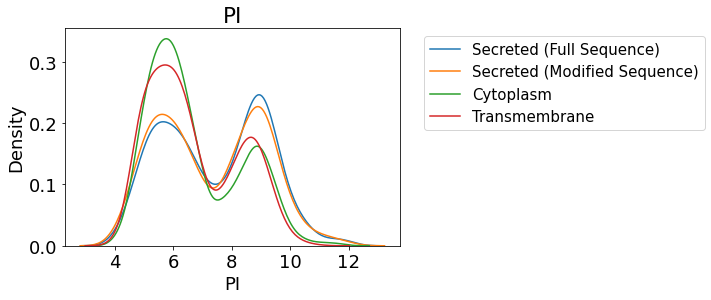

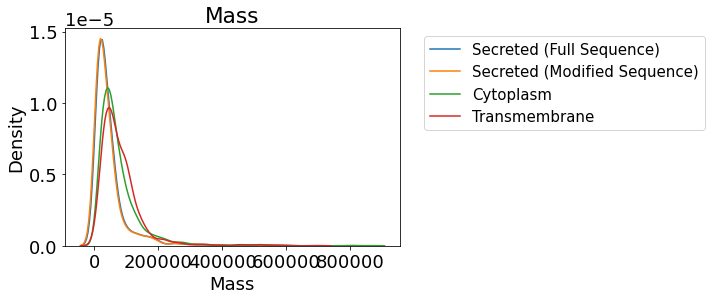

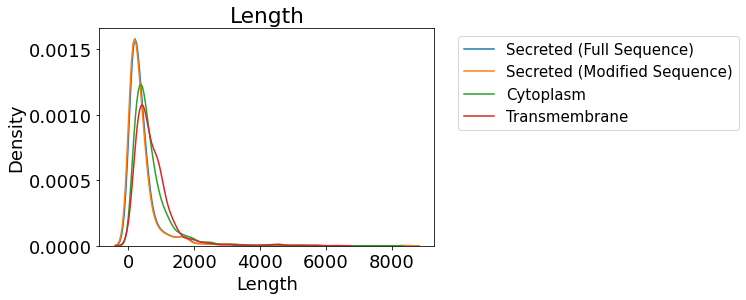

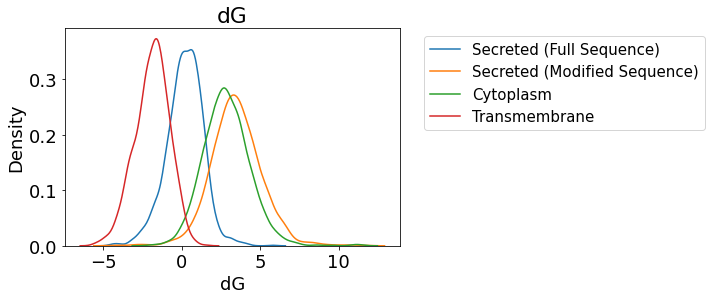

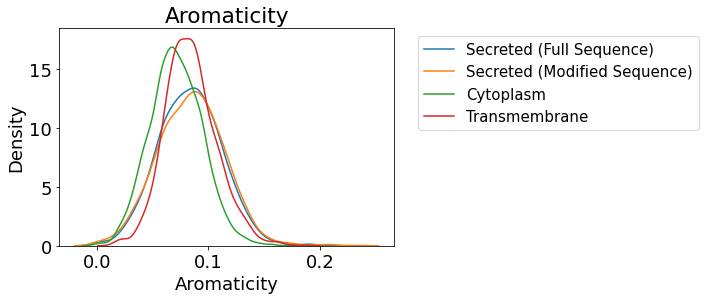

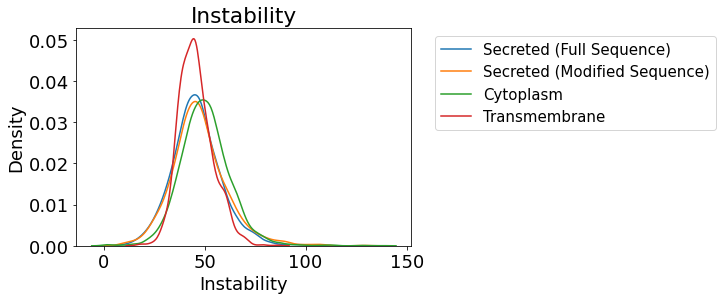

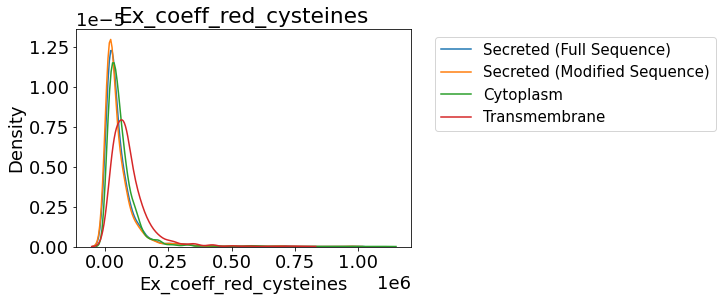

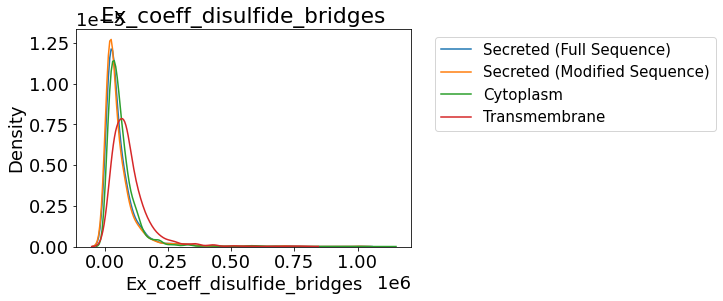

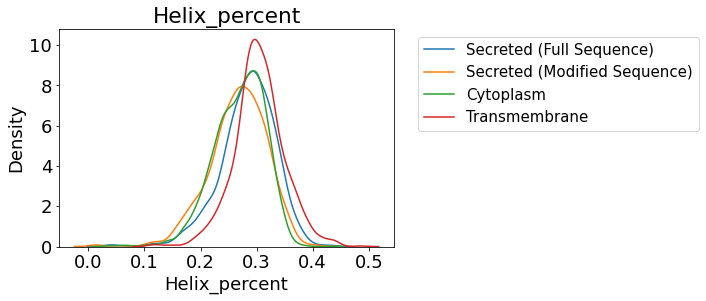

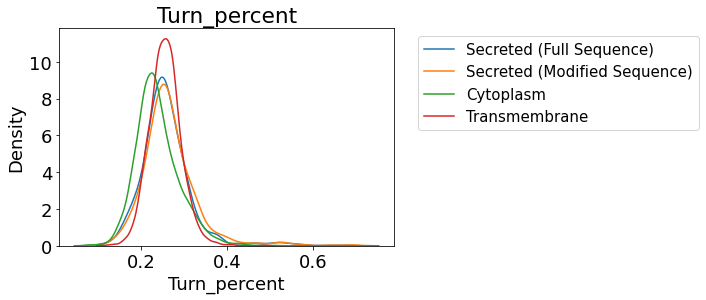

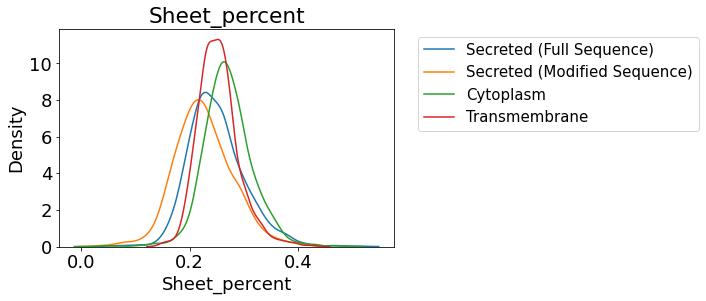

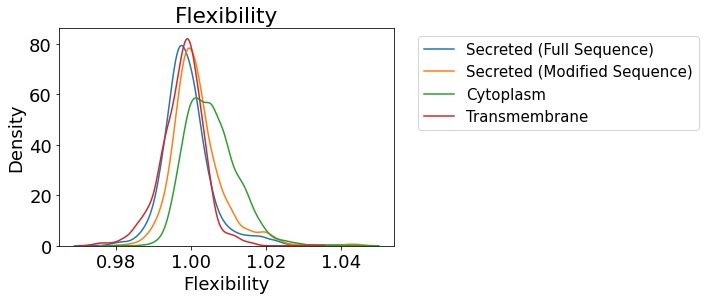

In [10]:
features = ['PI', 'Mass', 'Length', 'dG', 'Aromaticity', 'Instability', 
            'Ex_coeff_red_cysteines', 'Ex_coeff_disulfide_bridges', 
            'Helix_percent', 'Turn_percent',
           'Sheet_percent', 'Flexibility']
for feature in features:
    plot_function(feature)
    plt.show()

In [11]:
secreted_X = secreted[features]
transmembrane_X = transmembrane[features]
cytoplasm_X = cytoplasm[features]
secreted_noSP_X = secreted_noSP[features]

X = pd.concat([secreted_X, transmembrane_X, cytoplasm_X])
X = X.values
X2 = pd.concat([secreted_noSP_X, transmembrane_X, cytoplasm_X])
X2 = X2.values

In [12]:
secreted['location'] = 'secreted'
transmembrane['location'] = 'transmembrane'
cytoplasm['location'] = 'cytoplasm'
secreted_noSP['location'] = 'secreted'

secreted_y = np.array(secreted['location'])
transmembrane_y = np.array(transmembrane['location'])
cytoplasm_y = np.array(cytoplasm['location'])
secreted_noSP_y = np.array(secreted_noSP['location'])

y = np.concatenate([secreted_y, transmembrane_y, cytoplasm_y])
y2 = np.concatenate([secreted_noSP_y, transmembrane_y, cytoplasm_y])

In [13]:
def neural_net_classifier(X_train, X_test, y_train, y_test):
    """
    Performs MLP classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: MLP classification model (sklearn neural network)
    """
    model = MLPClassifier(max_iter=200)
    model.fit(X_train, y_train)
    return model

def ridge_regression_classifier(X_train, X_test, y_train, y_test):
    """
    Performs ridge regression classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: ridge regression classification model
    """
    model = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)
    model.fit(X_train, y_train)
    return model

def random_forest_classifier(X_train, X_test, y_train, y_test):
    """
    Uses random forests to classify based on the given X and y values.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: random forest classification model
    """
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = random_forest_classifier(X_train, X_test, y_train, y_test)

In [16]:
model.score(X_test, y_test)

0.901443816698054

Text(0.5, 0, 'Relative Importance')

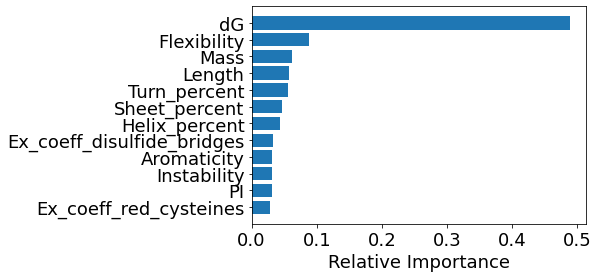

In [17]:
importances = model.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)),importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
model = random_forest_classifier(X_train, X_test, y_train, y_test)
model.score(X_test, y_test)

0.8713119899560577

Text(0.5, 0, 'Relative Importance')

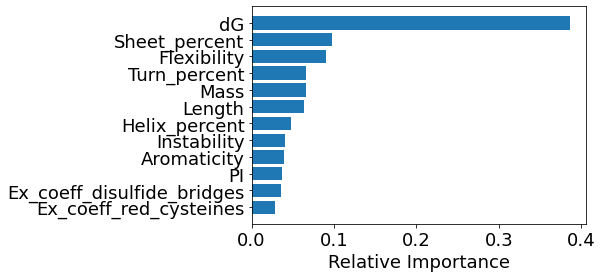

In [19]:
importances = model.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)),importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')